In [130]:
import os
import cv2
import torch
import random
import numpy as np
import sys
import os
import yaml
import torch.nn as nn

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from mask_generator.config import ModelConfig
from mask_generator.models.utils import create_model
from mask_generator.transforms import EvalTransform, TensorDecoder

# Model

In [131]:
def load_model_config_from_yaml(yaml_path: str) -> ModelConfig:
    """Load model configuration from a YAML file."""
    with open(yaml_path, 'r') as file:
        config_data = yaml.safe_load(file)
    return ModelConfig(**config_data.get('model', {}))

def load_model_from_config(config_path: str, checkpoint_path: str) -> nn.Module:
    """Load a model from a configuration file and a checkpoint."""
    config = load_model_config_from_yaml(config_path)
    model, pad_divisor = create_model(config)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Loading model to device: {device}")
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()
    return model, pad_divisor

def load_model_from_run_dir(run_dir: str) -> nn.Module:
    """Load a model from a run directory containing config and checkpoint files."""
    config_path = os.path.join(run_dir, 'config.yaml')
    checkpoint_path = os.path.join(run_dir, 'model.pth')
    if not os.path.exists(config_path) or not os.path.exists(checkpoint_path):
        raise FileNotFoundError("Configuration or checkpoint file not found in the run directory.")
    return load_model_from_config(config_path, checkpoint_path)

In [132]:
CAR_PICTURE_DIR = "../Datasets/car_pictures/"

pictures = []

for root, dirs, files in os.walk(CAR_PICTURE_DIR):
    for file in files:
        if file.endswith(".png"):
            pictures.append(os.path.join(root, file))

print(len(pictures))

11133


In [133]:
def load_image(image_path: str) -> np.ndarray:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [134]:
RUN_DIR = '../experiments/20250530_052145_c65426084f'

model, pad_divisor = load_model_from_run_dir(RUN_DIR)

image = load_image(random.choice(pictures))
print(f"Loaded image shape: {image.shape}")
transform = EvalTransform(pad_divisor=pad_divisor, to_tensor=True)
transformed = transform(image=image)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_tensor = transformed["image"]
image_tensor.shape

Loading model to device: cpu
Loaded image shape: (180, 320, 3)


torch.Size([3, 256, 464])

In [135]:
with torch.no_grad():
    output = model(image_tensor.unsqueeze(0).to(device))
    output = torch.sigmoid(output)

output.shape

torch.Size([1, 1, 256, 464])

Image shape: (256, 464, 3), Mask shape: (256, 464)


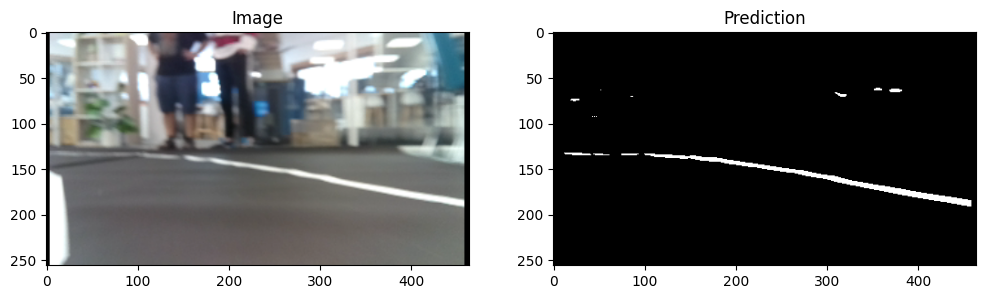

In [136]:
decoder = TensorDecoder()

image_np = decoder.to_image(image_tensor.cpu())
mask_np = decoder.to_mask(output.cpu())
print(f"Image shape: {image_np.shape}, Mask shape: {mask_np.shape}")

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(image_np)

plt.subplot(1, 2, 2)
plt.title("Prediction")
plt.imshow(mask_np, cmap='gray')
plt.show()

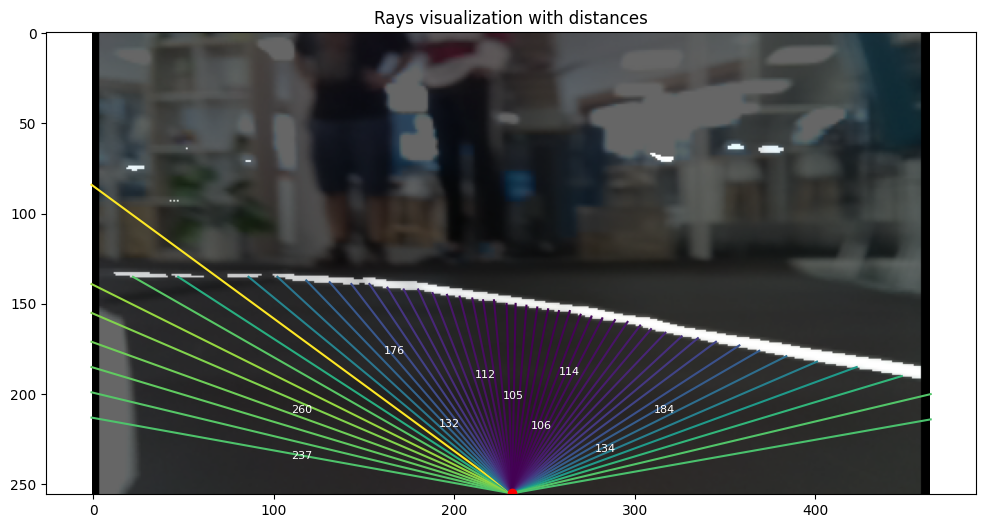

Distances: {'ray_0': 237, 'ray_1': 240, 'ray_2': 244, 'ray_3': 248, 'ray_4': 254, 'ray_5': 260, 'ray_6': 241, 'ray_7': 220, 'ray_8': 289, 'ray_9': 188, 'ray_10': 176, 'ray_11': 163, 'ray_12': 154, 'ray_13': 146, 'ray_14': 140, 'ray_15': 132, 'ray_16': 127, 'ray_17': 124, 'ray_18': 119, 'ray_19': 115, 'ray_20': 112, 'ray_21': 110, 'ray_22': 108, 'ray_23': 107, 'ray_24': 105, 'ray_25': 105, 'ray_26': 104, 'ray_27': 104, 'ray_28': 104, 'ray_29': 104, 'ray_30': 106, 'ray_31': 106, 'ray_32': 107, 'ray_33': 109, 'ray_34': 111, 'ray_35': 114, 'ray_36': 117, 'ray_37': 119, 'ray_38': 123, 'ray_39': 128, 'ray_40': 134, 'ray_41': 141, 'ray_42': 150, 'ray_43': 158, 'ray_44': 170, 'ray_45': 184, 'ray_46': 204, 'ray_47': 226, 'ray_48': 239, 'ray_49': 236}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# NumPy 2.x compatibility patch
def ensure_numpy_array(data):
    """Ensure data is a properly formatted NumPy array for ray calculations"""
    if isinstance(data, np.ndarray):
        # Make sure we're working with a 2D array
        if data.ndim == 2:
            return data
        elif data.ndim > 2:
            return data.squeeze()
    return np.array(data)

def generate_rays(mask, num_rays=50, fov_degrees=120, max_distance=None):
    """
    Generate rays from the bottom center of the mask and calculate distances to obstacles.
    Compatible with NumPy 2.x
    """
    # Ensure mask is properly formatted
    mask = ensure_numpy_array(mask)

    # Rest of the function remains the same
    height, width = mask.shape
    origin_x = width // 2
    origin_y = height - 1

    # Calculate the angle range
    fov_radians = np.radians(fov_degrees)
    half_fov = fov_radians / 2

    # Calculate the angles for each ray
    angles = np.linspace(-half_fov, half_fov, num_rays)

    ray_endpoints = []
    distances = {}

    if max_distance is None:
        max_distance = int(np.sqrt(width**2 + height**2))

    # Cast rays and find intersections
    for i, angle in enumerate(angles):
        # Direction vector
        dx = np.sin(angle)
        dy = -np.cos(angle)  # Negative because y-axis is inverted in images

        # Ray tracing
        found_obstacle = False
        for dist in range(1, max_distance):
            x = int(origin_x + dx * dist)
            y = int(origin_y + dy * dist)

            # Check if we're out of bounds
            if x < 0 or x >= width or y < 0 or y >= height:
                ray_endpoints.append((x, y))
                distances[f"ray_{i}"] = dist
                found_obstacle = True
                break

            # Check if we hit an obstacle (white pixel)
            if mask[y, x] > 0:
                ray_endpoints.append((x, y))
                distances[f"ray_{i}"] = dist
                found_obstacle = True
                break

        # If no obstacle was found, add the maximum distance
        if not found_obstacle:
            x = int(origin_x + dx * max_distance)
            y = int(origin_y + dy * max_distance)
            ray_endpoints.append((x, y))
            distances[f"ray_{i}"] = max_distance

    return distances, ray_endpoints

def show_rays(mask, ray_endpoints, distances, image=None, alpha=0.6, show_text=False,
              text_interval=5, colormap_name='viridis'):

    height, width = mask.shape
    origin_x = width // 2
    origin_y = height - 1

    plt.figure(figsize=(12, 6))

    if image is not None:
        if image.shape[:2] != mask.shape:
            raise ValueError("Image and mask must have the same height and width")
        plt.imshow(image, alpha=1.0)
        plt.imshow(mask, cmap='gray', alpha=alpha)
    else:
        plt.imshow(mask, cmap='gray')

    dist_values = np.array([distances[f"ray_{i}"] for i in range(len(ray_endpoints))])
    dist_norm = (dist_values - dist_values.min()) / (np.ptp(dist_values) + 1e-8)
    cmap = plt.get_cmap(colormap_name)

    for i, (end_x, end_y) in enumerate(ray_endpoints):

        color = cmap(dist_norm[i])

        plt.plot([origin_x, end_x], [origin_y, end_y], color=color)

        if show_text and i % text_interval == 0:
            distance = distances[f"ray_{i}"]

            mid_x = (origin_x + end_x) / 2
            mid_y = (origin_y + end_y) / 2
            offset = 20 * np.sin(i / 2.0)


            plt.text(mid_x, mid_y + offset, f"{distance}", color='white',
                    ha='center', va='center', fontsize=8)

    plt.plot(origin_x, origin_y, "ro")
    plt.title("Rays visualization with distances" if show_text else "Rays visualization")
    plt.axis("equal")
    plt.show()

# Generate rays and distances
distances, ray_endpoints = generate_rays(mask_np, num_rays=50, fov_degrees=160)
show_rays(mask_np, ray_endpoints, distances, image=image_np)
print("Distances:", distances)